In [ ]:
from pathlib import Path
from glob import glob
from copy import copy

import pandas as pd
import numpy as np
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import logomaker
from logomaker import Logo

import torch
from NegativeClassOptimization import config, ml, preprocessing

In [2]:
#import data and filter positive sequences
DATASETS_PATH = config.DATA_BASE_PATH / 'Frozen_MiniAbsolut_ML'

#to work with existing files names easier
tasks_dict = {'ONE_VS_NINE': '1v9', 'HIGH_VS_95LOW': 'high_vs_95low', 'HIGH_VS_LOOSER': 'high_vs_looser'}
task_template = {'ONE_VS_NINE': '{ag}__vs__9', 'HIGH_VS_95LOW': '{ag}_high__vs__{ag}_95low', 'HIGH_VS_LOOSER': '{ag}_high__vs__{ag}_looser'}
task_2TASK = {'vs 9': 'ONE_VS_NINE', 'vs Non-binder': 'HIGH_VS_95LOW', 'vs Weak': 'HIGH_VS_LOOSER'}


In [3]:
# Step 1: Calculate Marginal Frequencies
def calculate_marginal_frequencies(array):
    positions = array.shape[1]
    marginal_freqs = {}
    for i in range(positions):
        counts = Counter(array[:, i])
        total = len(array)
        marginal_freqs[i] = {aa: count / total for aa, count in counts.items()}
    return marginal_freqs

# Step 2: Calculate Observed Joint Frequencies
def calculate_joint_frequencies(array):
    positions = array.shape[1]
    joint_freqs = defaultdict(lambda: defaultdict(int))
    
    for seq in array:
        for i in range(positions):
            for j in range(i + 1, positions):  # Avoid duplicates (i, j)
                pair = (seq[i], seq[j])
                joint_freqs[(i, j)][pair] += 1

    # Normalize by total number of sequences
    total = len(array)
    for pos_pair in joint_freqs:
        for pair in joint_freqs[pos_pair]:
            joint_freqs[pos_pair][pair] /= total
            
    return {pos_pair: dict(joint_freqs[pos_pair]) for pos_pair in joint_freqs}

# Step 3: Calculate LD Metrics (including r2)
def calculate_ld(marginal_freqs, joint_freqs):
    """ Used to calculate linkage disequilibrium metrics (D and r2) """
    ld_results = {}
    
    for (i, j), joint_freq_dict in joint_freqs.items():
        ld_results[(i, j)] = {}
        for (aa_i, aa_j), P_ij in joint_freq_dict.items():
            P_i = marginal_freqs[i].get(aa_i, 0)
            P_j = marginal_freqs[j].get(aa_j, 0)
            D = P_ij - (P_i * P_j)  # Linkage disequilibrium coefficient
            if P_i > 0 and P_j > 0:
                #r2 = D**2 / (P_i * (1 - P_i) * P_j * (1 - P_j))
                r = D / np.sqrt((P_i * (1 - P_i) * P_j * (1 - P_j)))
            else:
                #r2 = 0
                r = 0
            #ld_results[(i, j)][(aa_i, aa_j)] = {'D': D, 'r2': r2}
            ld_results[(i, j)][(aa_i, aa_j)] = {'D': D, 'r': r}
    
    return ld_results

In [4]:
def seq_satisfy_filter(seq, filter_df):
    """Used to filter sequences that satisfy a given LD filter"""
    for i, row in filter_df.iterrows():
        pos_pair = row['Position Pair']
        aa_pair = row['Amino Acid Pair']
        if seq[pos_pair[0]] == aa_pair[0] and seq[pos_pair[1]] == aa_pair[1]:
            return True
    return False

In [5]:
def calc_restricted_joint_frequencies(df_aa_pairs, seq_array):
    """Used to calculate joint frequencies for a subset of amino acid pairs"""
    joint_freqs = defaultdict(lambda: defaultdict(int))
    for i, row in df_aa_pairs.iterrows():
        pos = row['Position Pair']
        aa_pairs = row['Amino Acid Pair']
        #calulate how many times aa_pair in positions pos are present in the sequences
        joint_freqs[pos][aa_pairs] = sum([1 for seq in seq_array if seq[pos[0]] == aa_pairs[0] and seq[pos[1]] == aa_pairs[1]])/len(seq_array)
    return joint_freqs


In [6]:
def model_mistakes_on_linked(ag, task, seed, split, linked_seq_df):
    TASK = task_2TASK[task]
    model_path = config.DATA_ML / f"{tasks_dict[TASK]}/seed_{seed}/split_{split}/{task_template[TASK].format(ag=ag)}/trained_model/data/model.pth"
    model = torch.load(model_path, map_location=torch.device('cpu'))

    linked_seq_df['X'] = linked_seq_df.Slide.apply(lambda x: preprocessing.onehot_encode(x))

    with torch.no_grad():
        X = np.array(linked_seq_df["X"].tolist())
        X_tensor = torch.tensor(X, dtype=torch.float32)  # type: ignore
        y_pred = model(X_tensor).round().detach().numpy().reshape(-1)
        y_true = linked_seq_df["y"].values
        error_rate = np.mean(y_pred != y_true)
    return error_rate

In [7]:
#Calculate aa pairs LD for each antigen based on positive sequences
for ag in config.ANTIGENS:

    train_path = glob(str(DATASETS_PATH/ f'high_vs_looser/seed_0/split_0/{ag}_high__vs__{ag}_looser/*train_dataset.tsv'))[0]
    test_path = glob(str(DATASETS_PATH/ f'high_vs_looser/seed_0/split_0/{ag}_high__vs__{ag}_looser/*test_dataset.tsv'))[0]
    df_train = pd.read_csv(train_path, sep='\t')
    df_test = pd.read_csv(test_path, sep='\t')
    df_train_pos = df_train[df_train['y'] == 1]
    df_test_pos = df_test[df_test['y'] == 1]
    seqs = np.concatenate([df_train_pos.Slide.values, df_test_pos.Slide.values], axis=0)

    sequences_array = np.array([list(seq) for seq in seqs])

    marginal_freqs = calculate_marginal_frequencies(sequences_array)
    joint_freqs = calculate_joint_frequencies(sequences_array)
    ld_results = calculate_ld(marginal_freqs, joint_freqs)
    #ld_df = pd.DataFrame([{'Position Pair': pos_pair, 'Amino Acid Pair': aa_pair, 'D': values['D'], 'r2': values['r2']}
    ld_df = pd.DataFrame([{'Position Pair': pos_pair, 'Amino Acid Pair': aa_pair, 'D': values['D'], 'r': values['r']}
                      for pos_pair, aa_dict in ld_results.items()
                      for aa_pair, values in aa_dict.items()])
    
    ld_df.to_csv(f'linkage_diseq/{ag}_LD_r.csv', index=False)


In [8]:
config.DATA_ML

PosixPath('/Users/aygulminnegalieva/Music/nco/negative-class-optimization/data/Frozen_MiniAbsolut_ML')

In [9]:
#Calculate aa pairs LD for each antigen based on negative sequences
#maybe lets do it for train and test together 

"""tasks_dict = {'ONE_VS_NINE': '1v9', 'HIGH_VS_95LOW': 'high_vs_95low', 'HIGH_VS_LOOSER': 'high_vs_looser'}
task_template = {'ONE_VS_NINE': '{ag}__vs__9', 'HIGH_VS_95LOW': '{ag}_high__vs__{ag}_95low', 'HIGH_VS_LOOSER': '{ag}_high__vs__{ag}_looser'}
task_2TASK = {'vs 9': 'ONE_VS_NINE', 'vs Non-binder': 'HIGH_VS_95LOW', 'vs Weak': 'HIGH_VS_LOOSER'}"""

for ag in config.ANTIGENS:
    for task, TASK in task_2TASK.items():
        train_path = glob(str(config.DATA_ML / f"{tasks_dict[TASK]}/seed_0/split_0/{task_template[TASK].format(ag=ag)}/*train_dataset.tsv"))[0]
        test_path = glob(str(config.DATA_ML / f"{tasks_dict[TASK]}/seed_0/split_0/{task_template[TASK].format(ag=ag)}/*test_dataset.tsv"))[0]

        df_test = pd.read_csv(test_path, sep='\t')
        df_test_neg = df_test[df_test['y'] == 0]
        df_train = pd.read_csv(train_path, sep='\t')
        df_train_neg = df_train[df_train['y'] == 0]

        df_neg = pd.concat([df_train_neg, df_test_neg], axis=0)
    
        seqs = np.array([list(seq) for seq in df_neg.Slide.values])

        marginal_freqs = calculate_marginal_frequencies(seqs)
        
        ld_df_pos = pd.read_csv(f'./linkage_diseq/{ag}_LD_r.csv')
        ld_df_pos['Position Pair'] = ld_df_pos['Position Pair'].apply(eval)
        ld_df_pos['Amino Acid Pair'] = ld_df_pos['Amino Acid Pair'].apply(eval)
        df_aa_pairs = ld_df_pos[['Position Pair', 'Amino Acid Pair']].copy()


        joint_freqs = calc_restricted_joint_frequencies(df_aa_pairs, seqs)

        ld_results = calculate_ld(marginal_freqs, joint_freqs)
        #ld_df_neg = pd.DataFrame([{'Position Pair': pos_pair, 'Amino Acid Pair': aa_pair, 'D': values['D'], 'r2': values['r2']}
        ld_df_neg = pd.DataFrame([{'Position Pair': pos_pair, 'Amino Acid Pair': aa_pair, 'D': values['D'], 'r': values['r']}
                        for pos_pair, aa_dict in ld_results.items()
                        for aa_pair, values in aa_dict.items()])
        
        out_name = '_'.join(task.split(' '))
        ld_df_pos.merge(ld_df_neg, on=['Position Pair', 'Amino Acid Pair'], how='inner', suffixes=('_pos', '_neg')).to_csv(f'linkage_diseq/{ag}_LD_pos_neg_{out_name}_r.csv', index=False)



In [125]:
df_ld_wk[(df_ld_wk['r_neg'] < 0) & (df_ld_wk['r_pos'] > 0)].shape[0]/df_ld_wk.shape[0]

0.23705351625262638

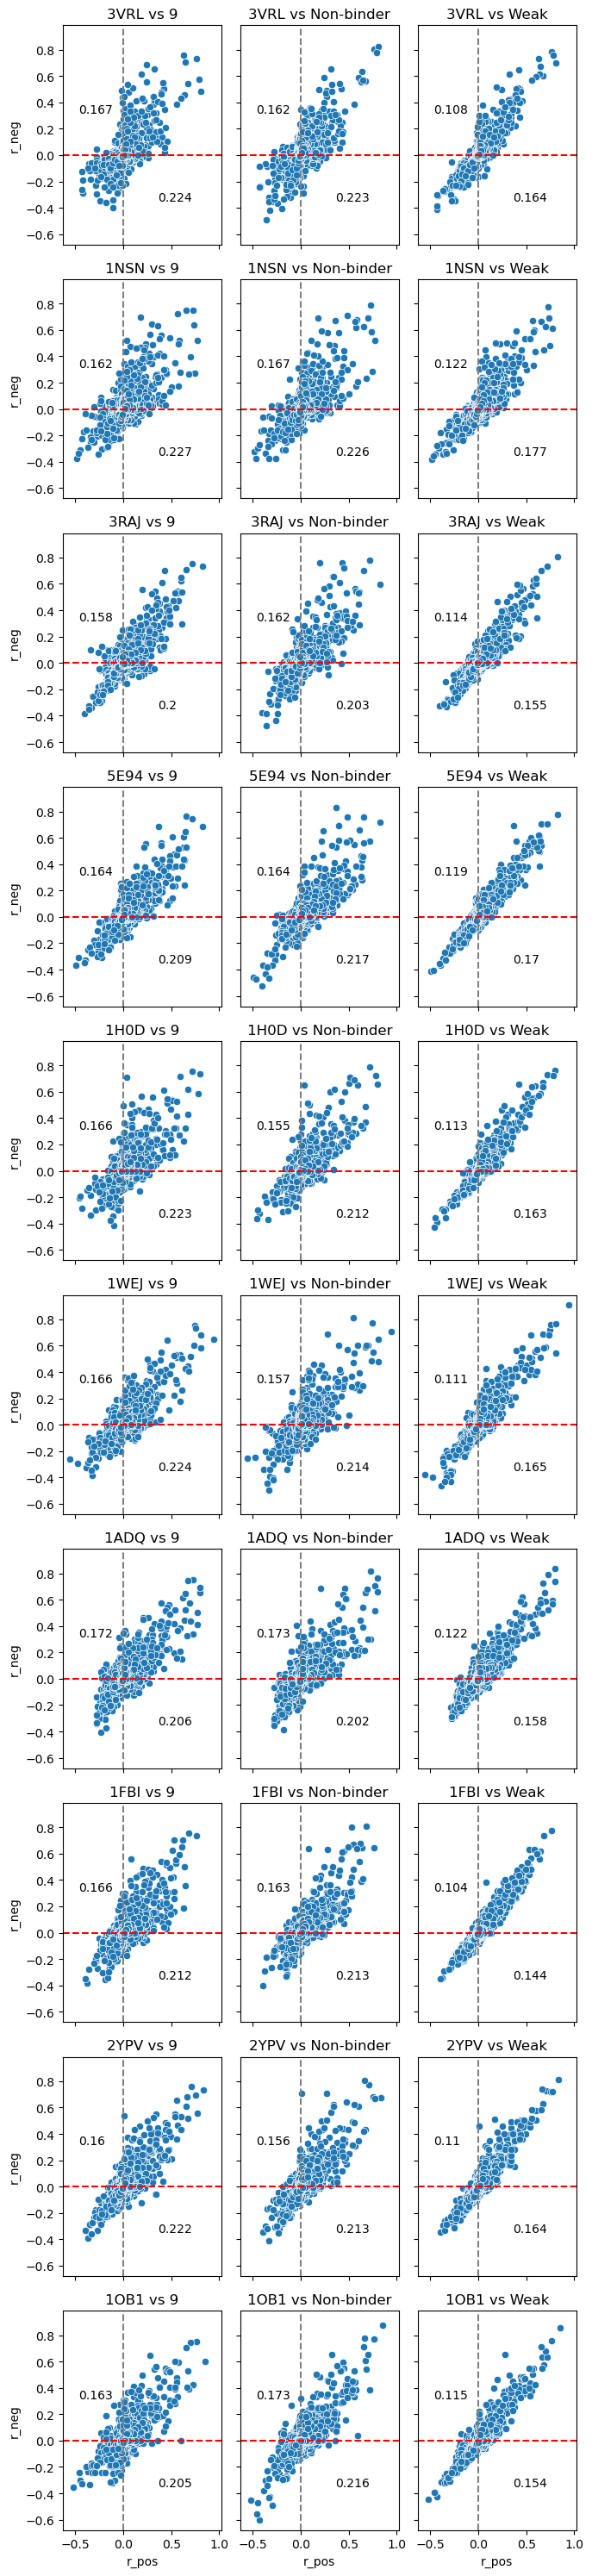

In [15]:
fig, ax = plt.subplots(10, 3, figsize=(7, 30), sharex=True, sharey=True)
for i, ag in enumerate(config.ANTIGENS):
    for j, task in enumerate(task_2TASK.keys()):
        out_name = '_'.join(task.split(' '))
        df = pd.read_csv(f'linkage_diseq/{ag}_LD_pos_neg_{out_name}_r.csv')


        sns.scatterplot(x='r_pos', y='r_neg', data=df, ax=ax[i, j])

        ax[i, j].set_title(f"{ag} {task}")
        #add a vline from 0 up
        ax[i, j].axvline(0, color='grey', linestyle='--')
        ax[i, j].axhline(0, color='red', linestyle='--')


        #calcuate proportion of points that lower than 0 in r_neg, but higher than 0 in r_pos. ax text
        prop_diff_pos_biased = df[(df['r_neg'] < 0) & (df['r_pos'] > 0)].shape[0]/df.shape[0]
        ax[i, j].text(0.6, 0.2, f"{round(prop_diff_pos_biased,3)}", transform=ax[i, j].transAxes)

        prop_diff_neg_biased = df[(df['r_neg'] > 0) & (df['r_pos'] < 0)].shape[0]/df.shape[0]
        ax[i, j].text(0.1, 0.6, f"{round(prop_diff_neg_biased,3)}", transform=ax[i, j].transAxes)




fig.tight_layout()

# it is important to account for sign of the D as well


In [ ]:
#well it seems vs Weak and positive are similar in terms of LD. Then how weak find difference between them?
#maybe some signal that is coming from negative data is learned is making it more robust for all negatives?

In [118]:
r2_cutoffs = np.arange(-0.4, 1, 0.2)
def analyze_error_rate_by_r2(ag, seed, split, tasks):

    # Load positive test data
    test_path = glob(str(DATASETS_PATH / f'high_vs_looser/seed_{seed}/split_{split}/{ag}_high__vs__{ag}_looser/*test_dataset.tsv'))[0]
    df_test = pd.read_csv(test_path, sep='\t')
    df_test_pos = df_test[df_test['y'] == 1].copy()

    # Load the LD data
    df_ld = pd.read_csv(f'./linkage_diseq/{ag}_LD.csv')
    df_ld['Position Pair'] = df_ld['Position Pair'].apply(eval)
    df_ld['Amino Acid Pair'] = df_ld['Amino Acid Pair'].apply(eval)
    df_ld_dict = df_ld.set_index(['Position Pair', 'Amino Acid Pair']).to_dict('index')

    # Function to get amino acid pairs
    def get_aa_pairs(seq):
        aa_pairs = []
        for i in range(len(seq)):
            for j in range(i + 1, len(seq)):
                aa_pairs.append(((i, j), (seq[i], seq[j])))
        return aa_pairs

    df_test_pos['aa_pairs'] = df_test_pos.Slide.apply(get_aa_pairs)
    df_test_pos['aa_r2s'] = df_test_pos['aa_pairs'].apply(lambda pairs: [df_ld_dict[pair]['r2'] for pair in pairs])

    error_rate_by_r2 = []

    for r2_cutoff in r2_cutoffs:
        df_test_pos[f'{r2_cutoff}_cutoff'] = df_test_pos['aa_r2s'].apply(lambda r2s: (np.array(r2s) > r2_cutoff).sum() > 0)
        linked_seq_df = df_test_pos[df_test_pos[f'{r2_cutoff}_cutoff']].copy()

        if len(linked_seq_df) != 0:
            for task in tasks:
                error_rate = model_mistakes_on_linked(ag, task, seed, split, linked_seq_df)
                error_rate_by_r2.append({'r2_cutoff': r2_cutoff, 'Task': task, 'Error Rate': error_rate})

    error_rate_by_r2_df = pd.DataFrame(error_rate_by_r2)
    return error_rate_by_r2_df

In [119]:
for ag in config.ANTIGENS:
    seed = 0
    split = 0
    tasks = ['vs Weak', 'vs Non-binder']
    error_rate_by_r2_df = analyze_error_rate_by_r2(ag, seed, split, tasks)
    error_rate_by_r2_df.to_csv(f'./linkage_diseq/{ag}_error_rate_by_r2.csv', index=False)

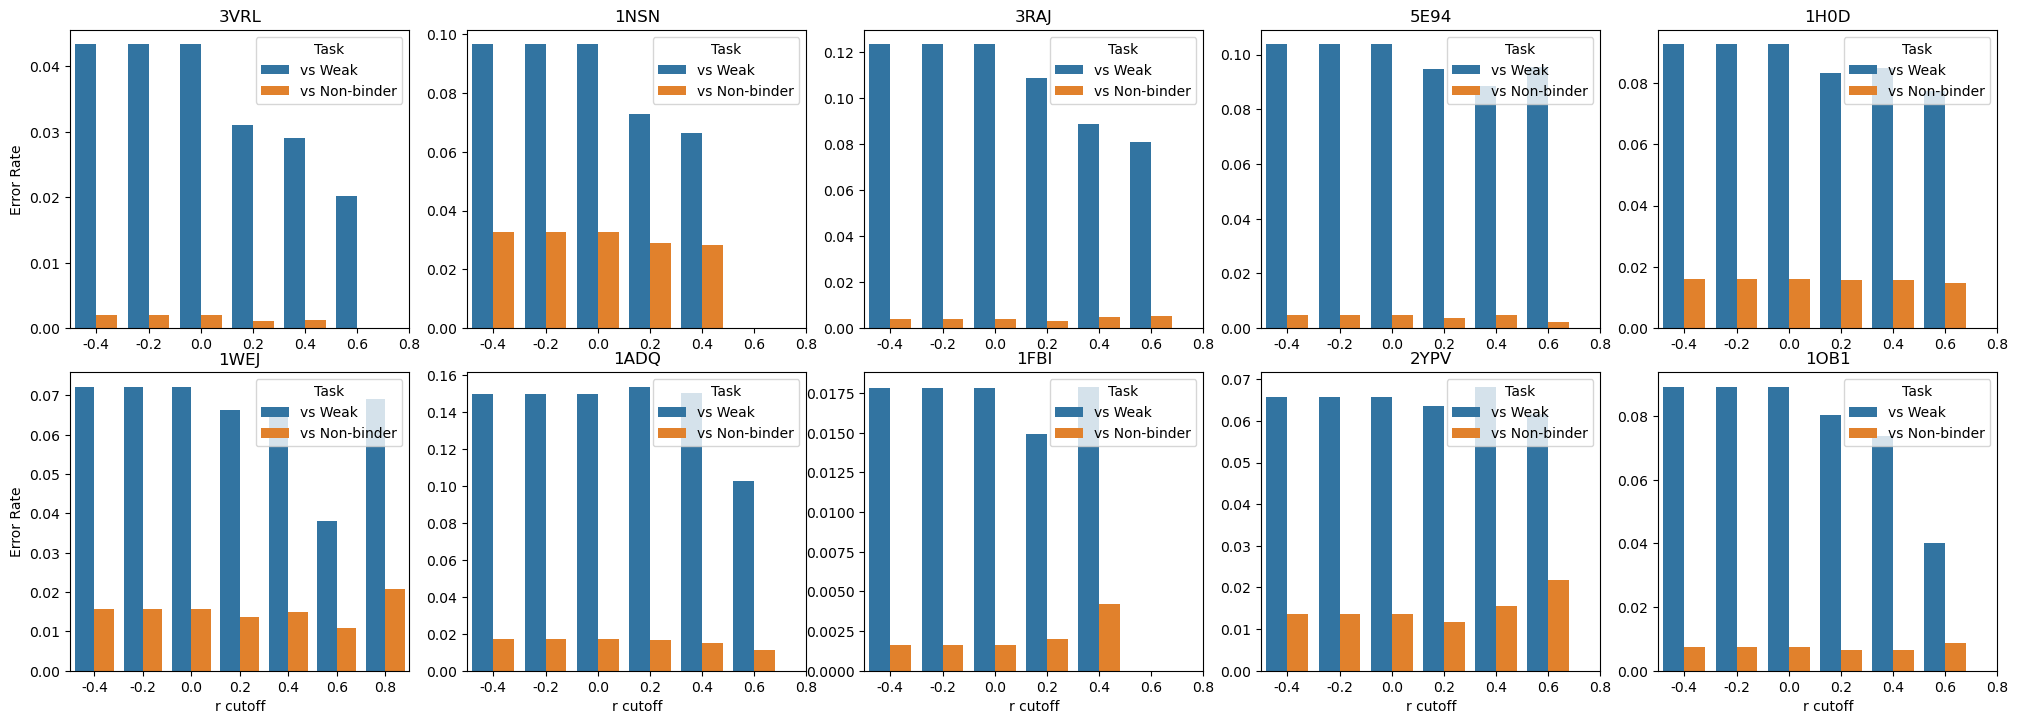

In [122]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.tight_layout()
for i, ag in enumerate(config.ANTIGENS):
    error_rate_by_r2_df = pd.read_csv(f'./linkage_diseq/{ag}_error_rate_by_r2.csv')
    sns.barplot(x='r2_cutoff', y='Error Rate', hue='Task', data=error_rate_by_r2_df, ax=ax[i // 5, i % 5])
    ax[i // 5, i % 5].set_title(ag)
    ax[i // 5, i % 5].set_xticks(range(7), labels=[f'{r2:.1f}' for r2 in r2_cutoffs])
    ax[i // 5, i % 5].set_ylabel('Error Rate' if i % 5 == 0 else '')
    ax[i // 5, i % 5].set_xlabel('r cutoff' if i // 5 == 1 else '')


### Models' error analysis
models trained on 'vs Weak' are more strict on positive data.

In [23]:
# I want to see confusio matrixes on ID tasks
#first upload models
#second upload test data
#third calculate confusion matrix

def calculate_confusion_matrix(ag, model_task, data_task, seed=0, split=0):
    TASK = task_2TASK[model_task]
    model_path = config.DATA_ML / f"{tasks_dict[TASK]}/seed_{seed}/split_{split}/{task_template[TASK].format(ag=ag)}/trained_model/data/model.pth"
    model = torch.load(model_path, map_location=torch.device('cpu'))

    DATA_TASK = task_2TASK[data_task]
    test_path = glob(str(DATASETS_PATH / f'{DATA_TASK}/seed_{seed}/split_{split}/{task_template[DATA_TASK].format(ag=ag)}/*test_dataset.tsv'))[0]
    df_test = pd.read_csv(test_path, sep='\t')
    df_test['X'] = df_test.Slide.apply(lambda x: preprocessing.onehot_encode(x))

    with torch.no_grad():
        X = np.array(df_test["X"].tolist())
        X_tensor = torch.tensor(X, dtype=torch.float32)  # type: ignore
        y_pred = model(X_tensor).round().detach().numpy().reshape(-1)
        y_true = df_test["y"].values
        confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    return confusion_matrix


In [ ]:
#for all antigens and tasks calculate confusion matrix get FN and FP rates and barplot
confusion_matrices = {}
for ag in config.ANTIGENS:
    for model_task in ['vs Weak', 'vs Non-binder']:
        for data_task in ['vs Weak', 'vs Non-binder']:
            confusion_matrix = calculate_confusion_matrix(ag, model_task, data_task)
            confusion_matrices[(ag, model_task, data_task)] = confusion_matrix

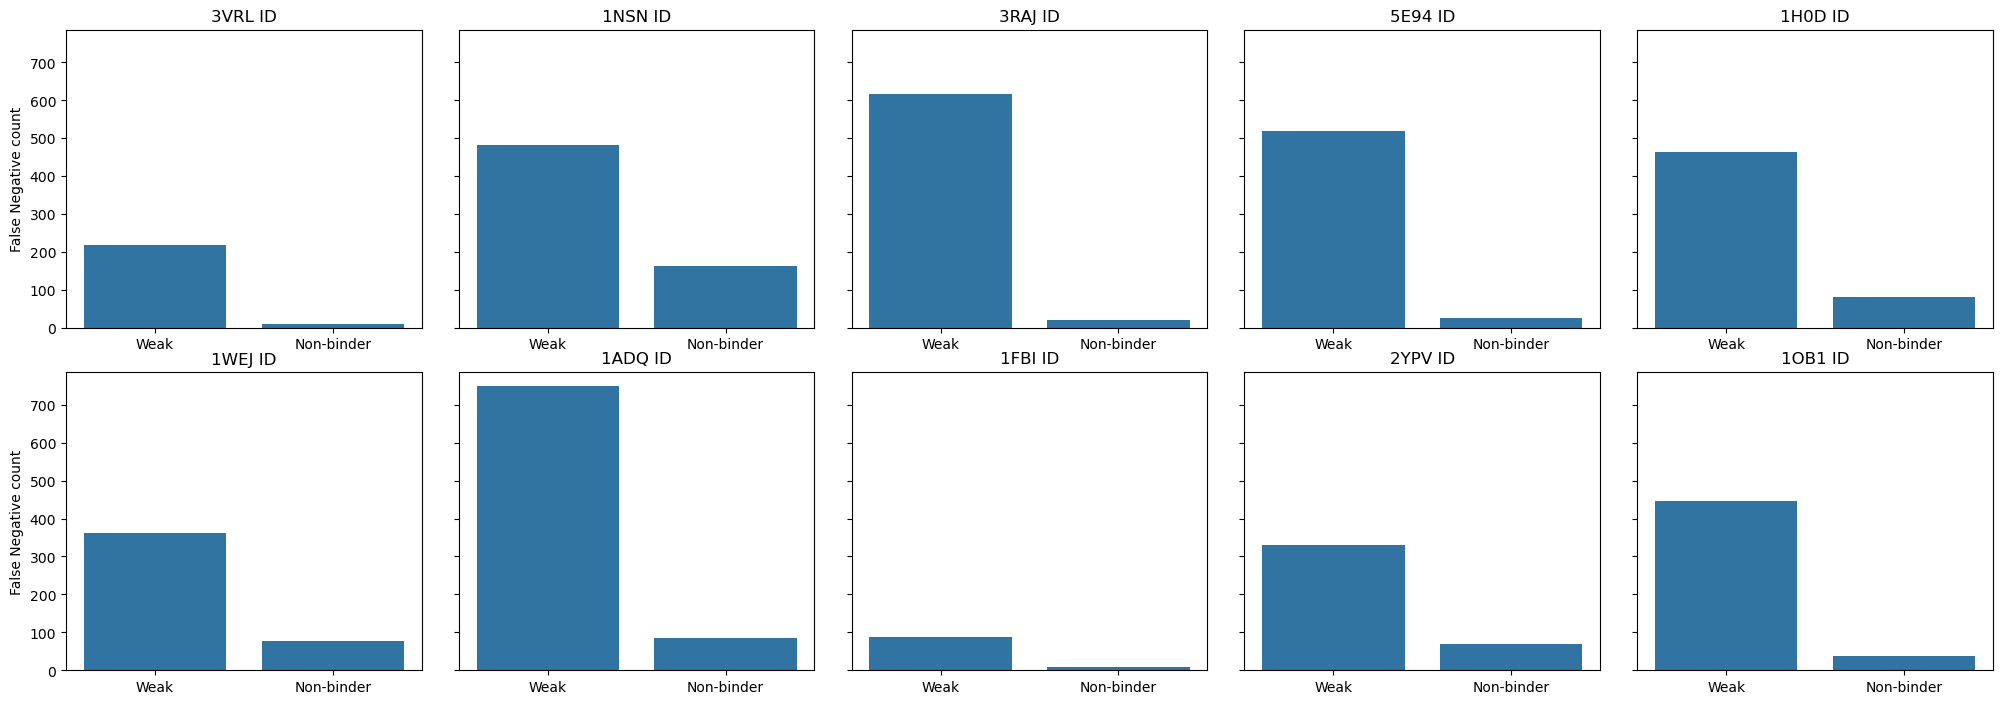

In [101]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7), sharey=True)
fig.tight_layout()
for i, ag in enumerate(config.ANTIGENS):
    confusion_matrix_id_wk = confusion_matrices[(ag, 'vs Weak', 'vs Weak')]
    confusion_matrix_id_nb = confusion_matrices[(ag, 'vs Non-binder', 'vs Non-binder')]
    FN_wk = confusion_matrix_id_wk[1, 0]
    FN_nb = confusion_matrix_id_nb[1, 0]

    sns.barplot(x=['Weak', 'Non-binder'], y=[FN_wk, FN_nb], ax=ax[i // 5, i % 5])
    ax[i // 5, i % 5].set_title(f'{ag} ID')
    ax[i // 5, i % 5].set_ylabel('False Negative count')

In [7]:
#isolate FN, FP,TN,TP and construct a logoplot with logomaker
import logomaker
from logomaker import Logo

#upload test data for an ag
ag = '1ADQ'
seed = 0
split = 0
DATA_TASK = 'HIGH_VS_LOOSER'
test_path = glob(str(DATASETS_PATH / f'{DATA_TASK}/seed_{seed}/split_{split}/{task_template[DATA_TASK].format(ag=ag)}/*test_dataset.tsv'))[0]
df_test = pd.read_csv(test_path, sep='\t')

#upload model
TASK = 'HIGH_VS_LOOSER'
model_path = config.DATA_ML / f"{tasks_dict[TASK]}/seed_{seed}/split_{split}/{task_template[TASK].format(ag=ag)}/trained_model/data/model.pth"
model = torch.load(model_path, map_location=torch.device('cpu'))

#calculate predictions and add this as a column to the dataframe
df_test['X'] = df_test.Slide.apply(lambda x: preprocessing.onehot_encode(x))
with torch.no_grad():
    X = np.array(df_test["X"].tolist())
    X_tensor = torch.tensor(X, dtype=torch.float32)  # type: ignore
    y_pred = model(X_tensor).round().detach().numpy().reshape(-1)
    df_test['y_pred'] = y_pred

#add column that will state where the seq fall TP, FN, FP, TN
def get_class(row):
    if row['y_pred'] == 1 and row['y'] == 1:
        return 'TP'
    elif row['y_pred'] == 1 and row['y'] == 0:
        return 'FP'
    elif row['y_pred'] == 0 and row['y'] == 1:
        return 'FN'
    else:
        return 'TN'

df_test['error_type'] = df_test.apply(get_class, axis=1)


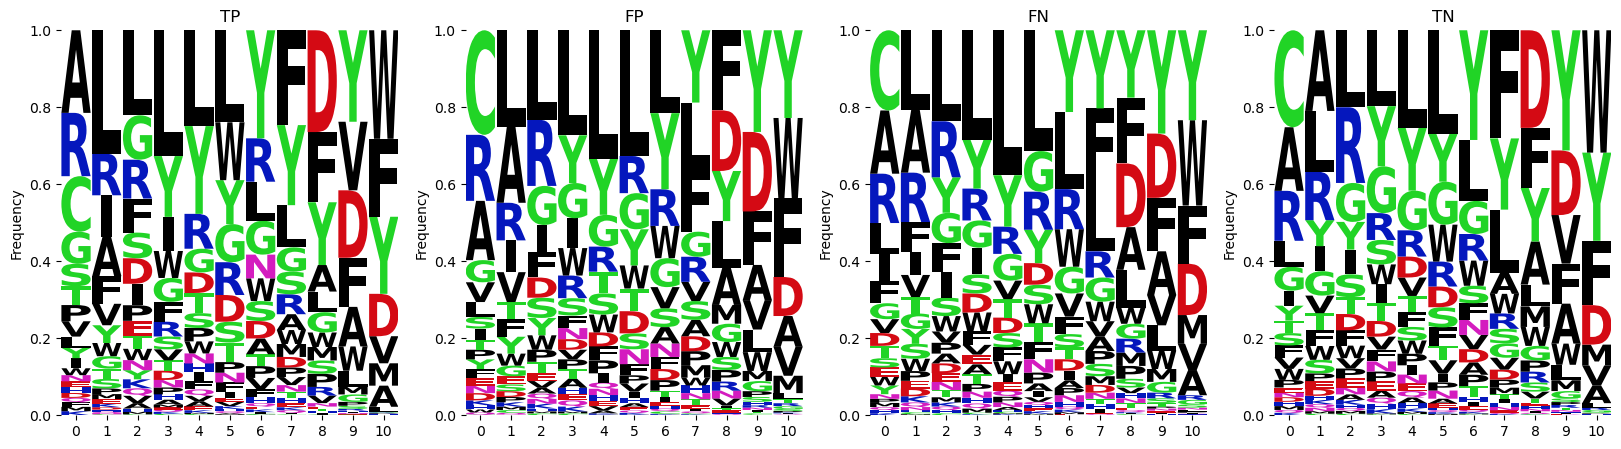

In [67]:
logos_pwm_dict = dict()
fig, ax = plt.subplots(1,4, figsize=(20, 5))

for i, error_type in enumerate(['TP', 'FP', 'FN', 'TN']):
    df_erro_type = df_test.query('error_type ==@error_type').Slide.values
    sequences_array = np.array([list(seq) for seq in df_erro_type])
    marginal_freqs = calculate_marginal_frequencies(sequences_array)

    #convert marginal freqs to logomaker format
    marginal_freqs_df = pd.DataFrame(marginal_freqs).fillna(0).T
    marginal_freqs_df = marginal_freqs_df[marginal_freqs_df.columns].sort_index(axis=1)
    logos_pwm_dict[error_type] = marginal_freqs_df

    #plot the logo
    logo = Logo(marginal_freqs_df, ax=ax[i])
    logo.style_xticks(anchor=0)
    logo.style_spines(visible=False)
    logo.ax.set_title(error_type)
    logo.ax.set_ylabel('Frequency')

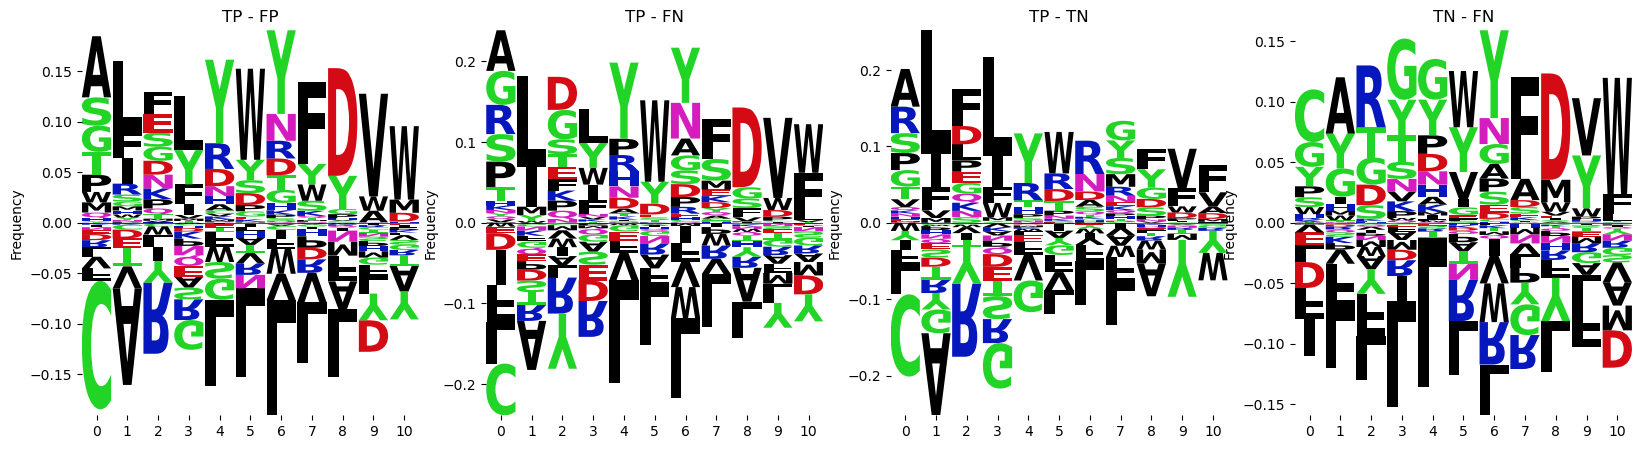

In [73]:
# find the diffrences between the logos
# calculate the difference between the logos
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, (error1, error2) in enumerate([('TP', 'FP'), ('TP', 'FN'), ('TP', 'TN'), ('TN', 'FN')]):
    diff_df = logos_pwm_dict[error1] - logos_pwm_dict[error2]
    logo = Logo(diff_df, ax=ax[i])
    logo.style_xticks(anchor=0)
    logo.style_spines(visible=False)
    logo.ax.set_title(f'{error1} - {error2}')
    logo.ax.set_ylabel('Frequency')

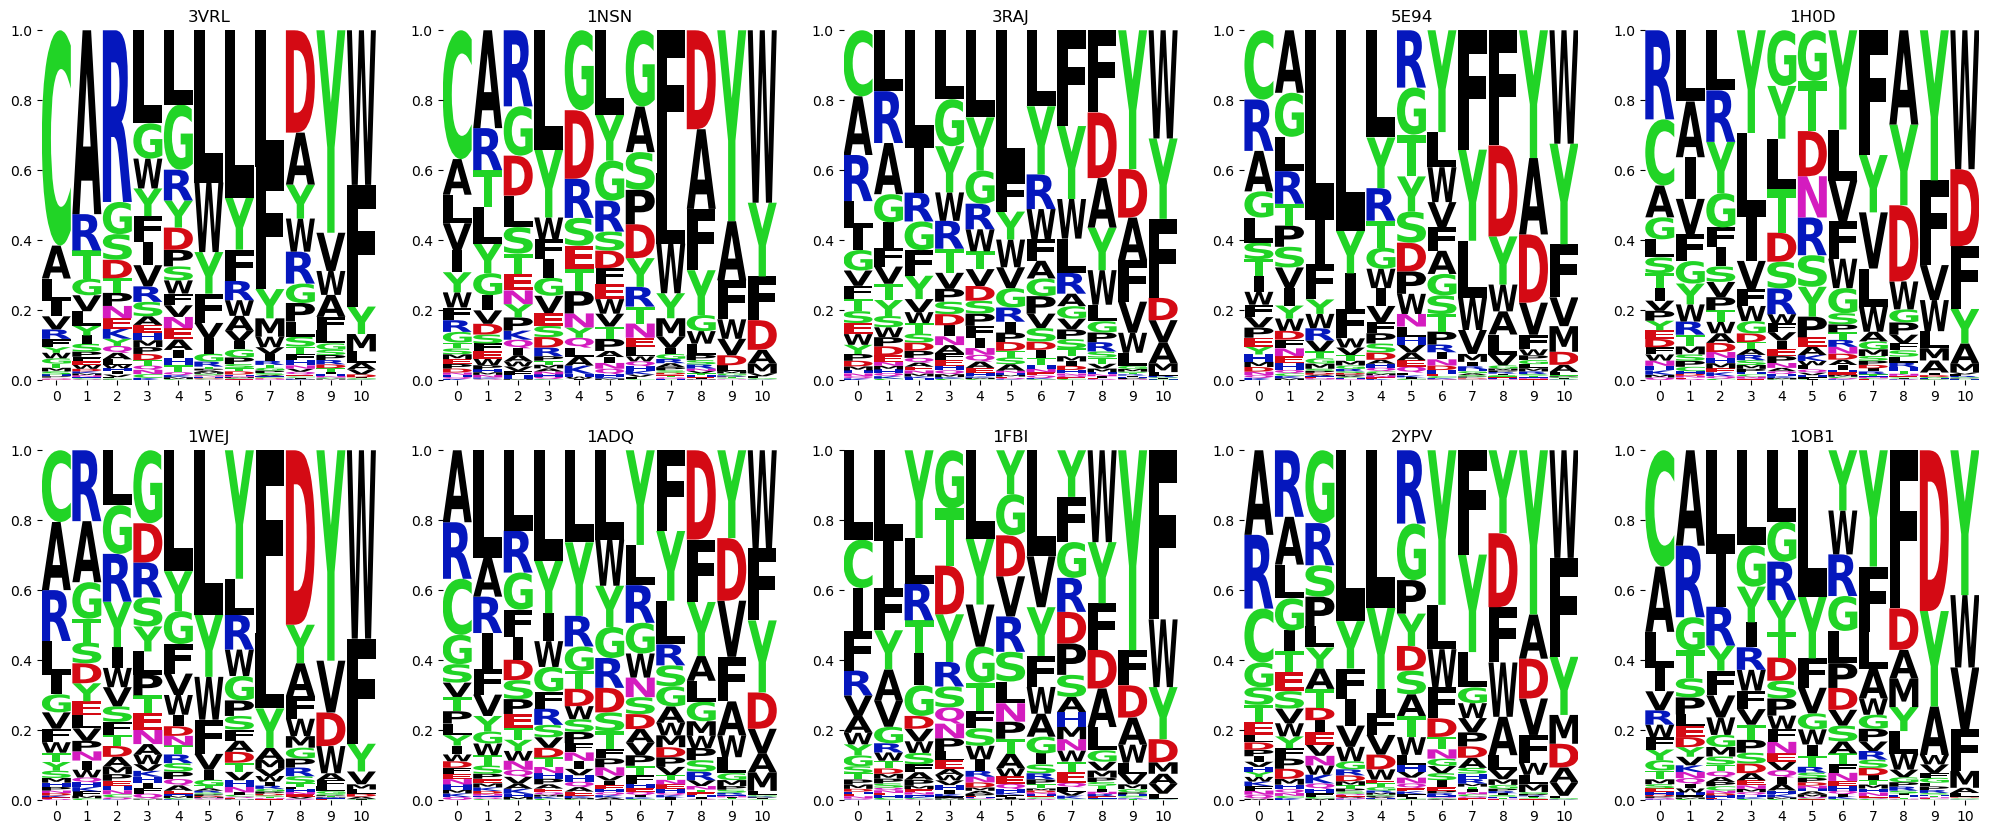

In [8]:
# lets take only positive data seq by antigen and calculate pwm and plot logos
fig, ax = plt.subplots(2, 5, figsize=(25, 10))
for i, ag in enumerate(config.ANTIGENS):

    train_path = glob(str(DATASETS_PATH/ f'high_vs_looser/seed_0/split_0/{ag}_high__vs__{ag}_looser/*train_dataset.tsv'))[0]
    df_train = pd.read_csv(train_path, sep='\t')
    df_test = pd.read_csv(test_path, sep='\t')
    df_train_pos = df_train[df_train['y'] == 1]
    seqs = df_train_pos.Slide.values
    marginal_freqs = calculate_marginal_frequencies(np.array([list(seq) for seq in seqs]))
    marginal_freqs_df = pd.DataFrame(marginal_freqs).fillna(0).T
    logo = Logo(marginal_freqs_df, ax=ax[i // 5, i % 5])
    logo.style_xticks(anchor=0)
    logo.style_spines(visible=False)
    logo.ax.set_title(ag)
    


In [9]:
ag_pos_pwm_entropy = dict()
for i, ag in enumerate(config.ANTIGENS):

    train_path = glob(str(DATASETS_PATH/ f'high_vs_looser/seed_0/split_0/{ag}_high__vs__{ag}_looser/*train_dataset.tsv'))[0]
    df_train = pd.read_csv(train_path, sep='\t')
    df_test = pd.read_csv(test_path, sep='\t')
    df_train_pos = df_train[df_train['y'] == 1]
    seqs = df_train_pos.Slide.values
    marginal_freqs = calculate_marginal_frequencies(np.array([list(seq) for seq in seqs]))

    epsilon = 1e-20
    pwm = pd.DataFrame(marginal_freqs).fillna(0).to_numpy()
    pwm += epsilon
    pwm_norm = pwm / pwm.sum(axis=0)
    
    entropy_matrix = -pwm_norm * np.log2(pwm_norm)
    entropy = entropy_matrix.sum(axis=0)
    total_entropy = entropy.sum()
    ag_pos_pwm_entropy[ag] = total_entropy
    

In [30]:
pd_logit_rule = pd.read_csv('/Users/aygulminnegalieva/Music/nco/negative-class-optimization/data/07e_LogitEnergyCorrelations.tsv', sep='\t')

In [36]:
pd_logit_rule_avg = pd_logit_rule.query("task_type == '1v9'").groupby('ag_pos').mean(['r', 'r2', 'r_pos'])

In [37]:
logit_rule_avg = pd_logit_rule_avg.loc[config.ANTIGENS]

In [38]:
logit_rule_avg

seed_id   split_id         r              p        r2     r_pos  \
ag_pos                                                                     
3VRL    0.666667  19.777778 -0.725667   0.000000e+00  0.528127 -0.725667   
1NSN    0.666667  19.777778  0.182840   7.938714e-27  0.033746  0.182840   
3RAJ    0.666667  19.777778 -0.323437   1.332224e-90  0.105179 -0.323437   
5E94    0.666667  19.777778 -0.562093   0.000000e+00  0.316143 -0.562093   
1H0D    0.666667  19.777778  0.040724   9.672708e-02  0.002246  0.040724   
1WEJ    0.666667  19.777778 -0.073511   7.294636e-04  0.005778 -0.073511   
1ADQ    0.666667  19.777778 -0.033914   1.145507e-01  0.001356 -0.033914   
1FBI    0.666667  19.777778 -0.370380  8.058389e-120  0.137847 -0.370380   
2YPV    0.666667  19.777778 -0.059196   5.618152e-03  0.004000 -0.059196   
1OB1    0.666667  19.777778 -0.335746   4.218765e-99  0.113293 -0.335746   

          r_pos2          p_pos     slope   intercept  ...  Energy_mean  \
ag_pos                                                 ...                
3VRL    0.528127   0.000000e+00 -0.268710  -96.254983  ...   -98.327381   
1NSN    0.033746   7.938714e-27  0.056513  -92.281851  ...   -91.790259   
3RAJ    0.105179   1.332224e-90 -0.173599 -101.202707  ...  -101.773499   
5E94    0.316143   0.000000e+00 -0.180119  -96.677405  ...   -97.729520   
1H0D    0.002246   9.672708e-02  0.016937  -83.590175  ...   -83.510482   
1WEJ    0.005778   7.294636e-04 -0.019792  -74.343444  ...   -74.458192   
1ADQ    0.001356   1.145507e-01 -0.020137  -95.866187  ...   -95.941122   
1FBI    0.137847  8.058389e-120 -0.144263  -90.706624  ...   -91.613985   
2YPV    0.004000   5.618152e-03 -0.021918  -96.702263  ...   -96.827961   
1OB1    0.113293   4.218765e-99 -0.191241  -93.552500  ...   -94.411870   

        Energy_std  logits_pos_mean  logits_pos_std  Energy_pos_mean  \
ag_pos                                                                 
3VRL      1.663281         7.879205        4.580304       -98.327381   
1NSN      1.708218         8.716830        5.538167       -91.790259   
3RAJ      1.370495         3.306022        2.562345      -101.773499   
5E94      1.282410         5.843384        4.004480       -97.729520   
1H0D      1.311012         4.670687        3.175953       -83.510482   
1WEJ      1.142373         5.827461        4.281082       -74.458192   
1ADQ      1.637131         3.711885        2.746173       -95.941122   
1FBI      1.410292         6.353043        3.641872       -91.613985   
2YPV      1.464136         5.762636        3.954014       -96.827961   
1OB1      1.680918         4.554446        2.975361       -94.411870   

        Energy_pos_std  logits_neg_mean  logits_neg_std  Energy_neg_mean  \
ag_pos                                                                     
3VRL          1.663281              NaN             NaN              NaN   
1NSN          1.708218              NaN             NaN              NaN   
3RAJ          1.370495              NaN             NaN              NaN   
5E94          1.282410              NaN             NaN              NaN   
1H0D          1.311012              NaN             NaN              NaN   
1WEJ          1.142373              NaN             NaN              NaN   
1ADQ          1.637131              NaN             NaN              NaN   
1FBI          1.410292              NaN             NaN              NaN   
2YPV          1.464136              NaN             NaN              NaN   
1OB1          1.680918              NaN             NaN              NaN   

        Energy_neg_std  
ag_pos                  
3VRL               NaN  
1NSN               NaN  
3RAJ               NaN  
5E94               NaN  
1H0D               NaN  
1WEJ               NaN  
1ADQ               NaN  
1FBI               NaN  
2YPV               NaN  
1OB1               NaN  

[10 rows x 24 columns]

In [39]:
logit_rule_avg.columns

Index(['seed_id', 'split_id', 'r', 'p', 'r2', 'r_pos', 'r_pos2', 'p_pos',
       'slope', 'intercept', 'slope_pos', 'intercept_pos', 'logits_mean',
       'logits_std', 'Energy_mean', 'Energy_std', 'logits_pos_mean',
       'logits_pos_std', 'Energy_pos_mean', 'Energy_pos_std',
       'logits_neg_mean', 'logits_neg_std', 'Energy_neg_mean',
       'Energy_neg_std'],
      dtype='object')

In [40]:
pwm_entropy_df = pd.DataFrame.from_dict(ag_pos_pwm_entropy, orient='index', columns=['entropy'])

In [41]:
df_rule_entr = logit_rule_avg.merge(pwm_entropy_df, left_index=True, right_index=True)

In [42]:
df_rule_entr.columns

Index(['seed_id', 'split_id', 'r', 'p', 'r2', 'r_pos', 'r_pos2', 'p_pos',
       'slope', 'intercept', 'slope_pos', 'intercept_pos', 'logits_mean',
       'logits_std', 'Energy_mean', 'Energy_std', 'logits_pos_mean',
       'logits_pos_std', 'Energy_pos_mean', 'Energy_pos_std',
       'logits_neg_mean', 'logits_neg_std', 'Energy_neg_mean',
       'Energy_neg_std', 'entropy'],
      dtype='object')

Text(0, 0.5, 'Average Logit energy correlation')

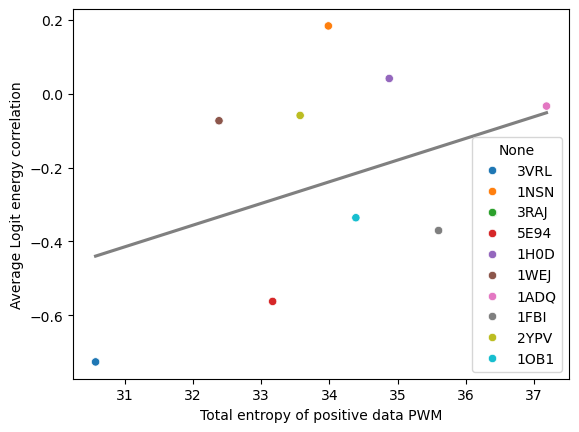

In [56]:
sns.scatterplot(x='entropy', y='r_pos', data = df_rule_entr, hue=df_rule_entr.index)
sns.regplot(x='entropy', y='r_pos', data = df_rule_entr, ci=None,scatter = False, color='grey')
plt.xlabel('Total entropy of positive data PWM')
plt.ylabel('Average Logit energy correlation')

In [24]:
tasks_dict

{'ONE_VS_NINE': '1v9',
 'HIGH_VS_95LOW': 'high_vs_95low',
 'HIGH_VS_LOOSER': 'high_vs_looser'}

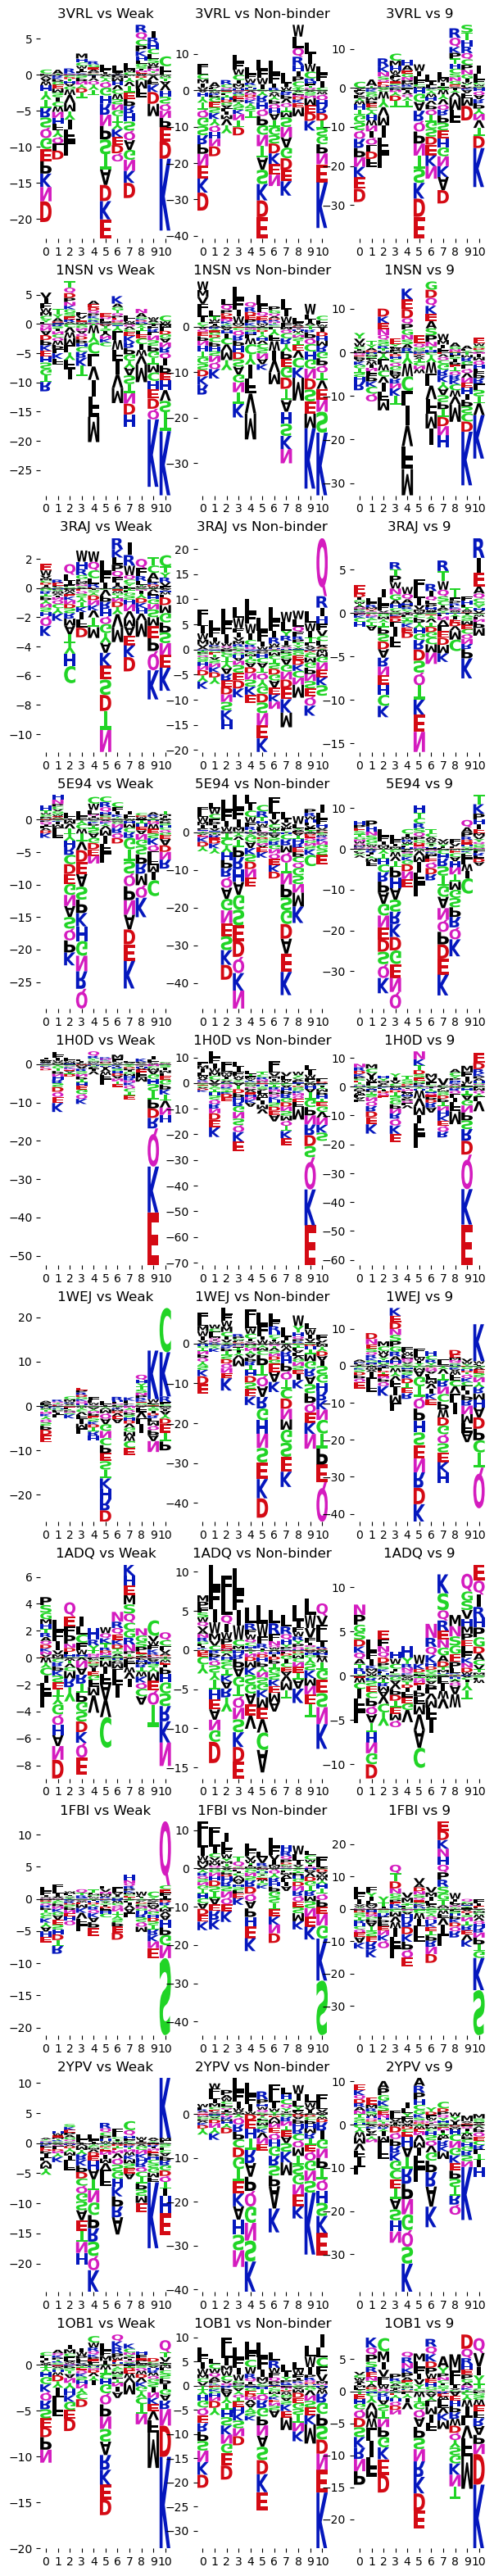

In [28]:
#lets now for each antigen plot log2 enrichment of positive data over negative data
#first upload negative data
fig, ax = plt.subplots(10, 3, figsize=(7, 40))
for i, ag in enumerate(config.ANTIGENS):
    for j, task in enumerate(['vs Weak', 'vs Non-binder', 'vs 9']):
        TASK = task_2TASK[task]
        train_path = glob(str(config.DATA_ML / f"{tasks_dict[TASK]}/seed_0/split_0/{task_template[TASK].format(ag=ag)}/*train_dataset.tsv"))[0]
        df_train = pd.read_csv(train_path, sep='\t')
        neg_seq = df_train[df_train['y'] == 0].Slide.values
        pos_seq = df_train[df_train['y'] == 1].Slide.values     
        marginal_freqs_neg = calculate_marginal_frequencies(np.array([list(seq) for seq in neg_seq]))
        df_neg = pd.DataFrame(marginal_freqs_neg).fillna(0).T
        marginal_freqs_pos = calculate_marginal_frequencies(np.array([list(seq) for seq in pos_seq]))
        df_pos = pd.DataFrame(marginal_freqs_pos).fillna(0).T       
        #find smallest positive value
        min_pos = df_pos[df_pos > 0].min().min()
        min_neg = df_neg[df_neg > 0].min().min()
        placeholder = min(min_pos, min_neg)*1e-3
        enrichment_df = np.log2((df_pos + placeholder) / (df_neg + placeholder))     
        
        logo = Logo(enrichment_df, ax=ax[i, j])
        logo.style_xticks(anchor=0)
        logo.style_spines(visible=False)
        logo.ax.set_title(f'{ag} {task}')



In [ ]:
#Can I correlate logo plots?


In [31]:
#lets now for each antigen plot log2 enrichment of positive data over negative data
#first upload negative data
dict_ag_enrichment = []
for i, ag in enumerate(config.ANTIGENS):
    dict_enrichment = dict()
    for j, task in enumerate(['vs Weak', 'vs Non-binder', 'vs 9']):
        TASK = task_2TASK[task]
        train_path = glob(str(config.DATA_ML / f"{tasks_dict[TASK]}/seed_0/split_0/{task_template[TASK].format(ag=ag)}/*train_dataset.tsv"))[0]
        df_train = pd.read_csv(train_path, sep='\t')
        neg_seq = df_train[df_train['y'] == 0].Slide.values
        pos_seq = df_train[df_train['y'] == 1].Slide.values     
        marginal_freqs_neg = calculate_marginal_frequencies(np.array([list(seq) for seq in neg_seq]))
        df_neg = pd.DataFrame(marginal_freqs_neg).fillna(0).T
        marginal_freqs_pos = calculate_marginal_frequencies(np.array([list(seq) for seq in pos_seq]))
        df_pos = pd.DataFrame(marginal_freqs_pos).fillna(0).T       
        #find smallest positive value
        min_pos = df_pos[df_pos > 0].min().min()
        min_neg = df_neg[df_neg > 0].min().min()
        placeholder = min(min_pos, min_neg)*1e-3
        enrichment_df = np.log2((df_pos + placeholder) / (df_neg + placeholder))
        dict_enrichment[task] = enrichment_df
    #correlate
    for j, task1 in enumerate(['vs Weak', 'vs Non-binder', 'vs 9']):
        for k, task2 in enumerate(['vs Weak', 'vs Non-binder', 'vs 9']):
            corr = dict_enrichment[task1].corrwith(dict_enrichment[task2], axis=1).mean()
            dict_ag_enrichment.append({'Antigen': ag, 'Task1': task1, 'Task2': task2, 'Correlation': corr})

df_ag_enrichment = pd.DataFrame(dict_ag_enrichment)

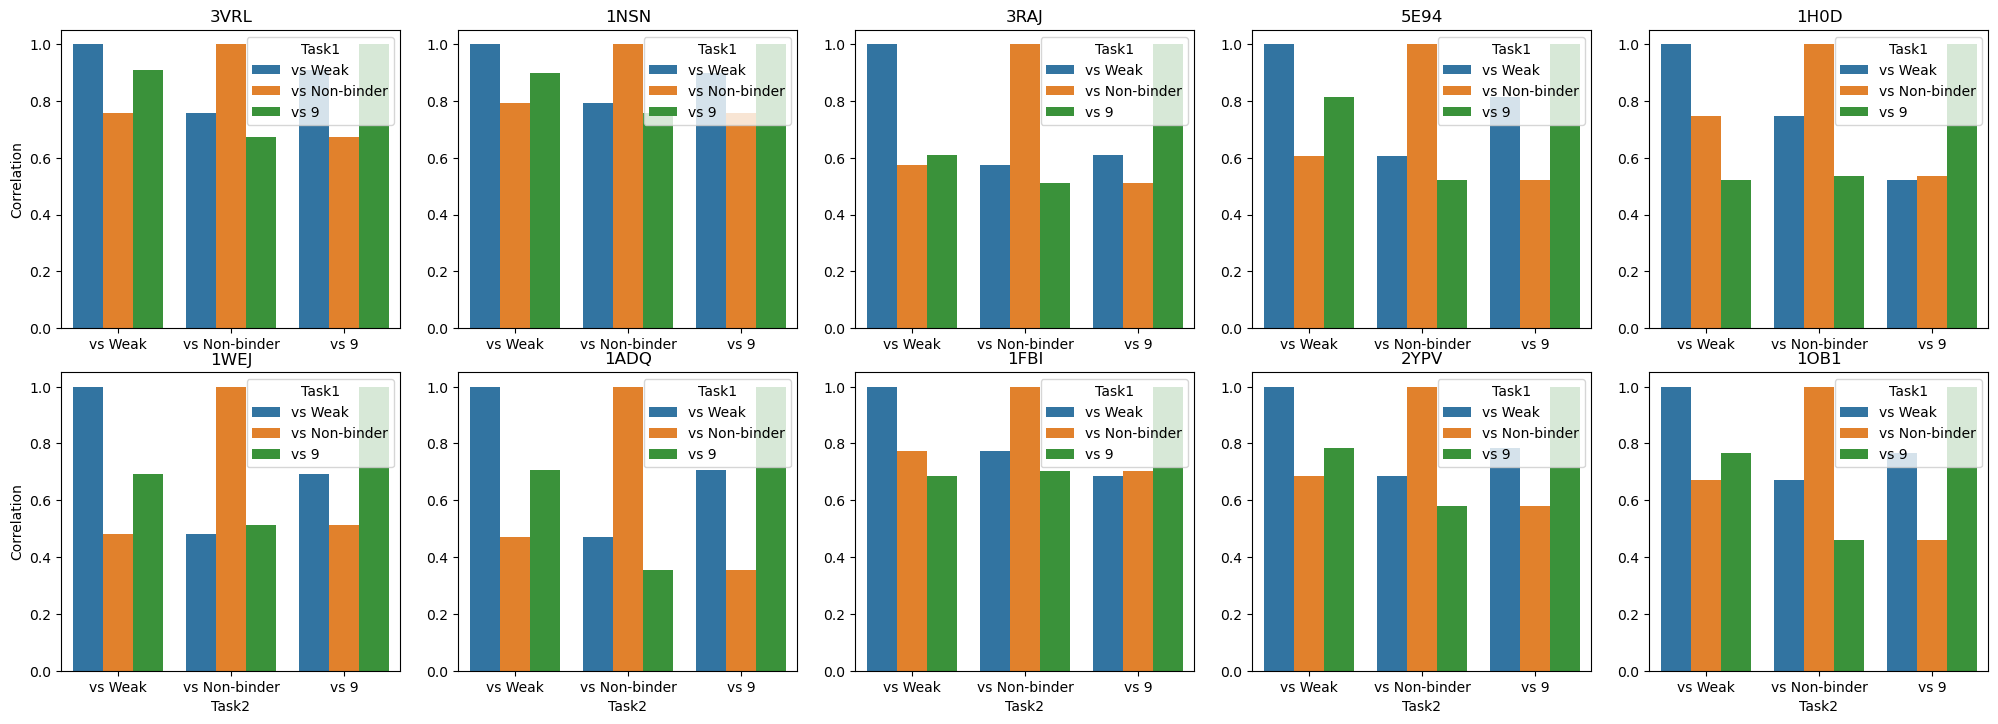

In [33]:
#plot df_ag_enrichment barplot
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.tight_layout()
for i, ag in enumerate(config.ANTIGENS):
    df_ag_enrichment_ag = df_ag_enrichment[df_ag_enrichment['Antigen'] == ag]
    sns.barplot(x='Task2', y='Correlation', hue='Task1', data=df_ag_enrichment_ag, ax=ax[i // 5, i % 5])
    ax[i // 5, i % 5].set_title(ag)
    ax[i // 5, i % 5].set_ylabel('Correlation' if i % 5 == 0 else '')
    ax[i // 5, i % 5].set_xlabel('Task2' if i // 5 == 1 else '')


In [199]:
attr

-0.0

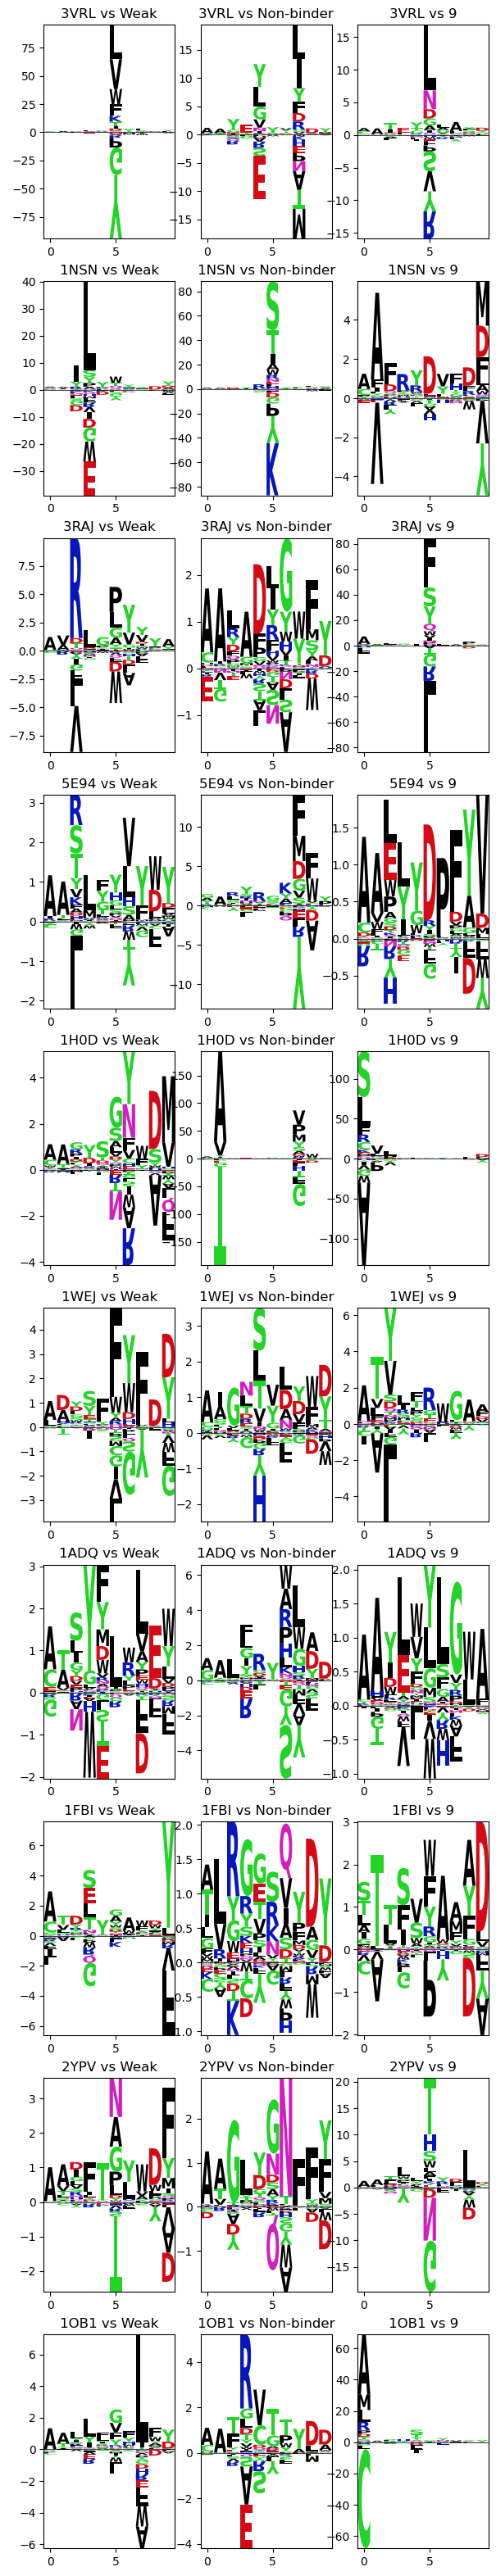

In [201]:
#ok I have attributions 
fig, ax = plt.subplots(10, 3, figsize=(7, 40))
for i, ag in enumerate(config.ANTIGENS):
    for j, task in enumerate(['vs Weak', 'vs Non-binder', 'vs 9']):
        TASK = task_2TASK[task]
        attr_path = config.DATA_ML / f"{tasks_dict[TASK]}/seed_0/split_0/{task_template[TASK].format(ag=ag)}/attributions/v2.0-2/attribution_records.json"
        #read json file and convert to dataframe
        with open(attr_path) as f:
            attr_dict = json.load(f)
        attr_df = pd.DataFrame(attr_dict)

        #logo
        attr_per_pos_dict = {key: {key: 0 for key in config.AMINOACID_ALPHABET} for key in range(10)}
        attr_series  = attr_df['DeepLIFT_LOCAL_v2.0-2'].apply(lambda x:np.array(x[0])/sum(x[0]))

        for pos in range(10):
            aa_in_position = attr_df.slide.apply(lambda x: x[pos]).values
            atrr_for_pos = attr_series.apply(lambda x: x[pos])
            for aa, attr in zip(aa_in_position, atrr_for_pos):
                attr_per_pos_dict[pos][aa] += attr

        attr_per_aa_df = pd.DataFrame(attr_per_pos_dict)
        normalized_attr_df = attr_per_aa_df.div(attr_per_aa_df.sum(axis=0), axis=1).T # we might need another normalization here

        Logo(normalized_attr_df, ax=ax[i, j])
        ax[i, j].set_title(f'{ag} {task}')




In [ ]:
attr_df['DeepLIFT_LOCAL_v2.0-2'].apply(lambda x:np.array(x[0])/sum(x[0])) # well what negative attributions mean? 

0       [0.014929709443631768, 0.0, 0.0, 0.0, 0.002303...
1       [0.011448215684266946, 0.0, 0.0, 0.0, 0.0, 0.0...
2       [0.0, 0.0, 0.04264585602710515, 0.025447674246...
3       [0.0, 0.0, 0.052791995825246484, 0.0, 0.0, 0.0...
4       [0.007758597726459656, 0.0872205014596191, 0.0...
                              ...                        
9990    [-0.0, -0.0, -0.03218815538579635, -0.0, 0.022...
9991    [-0.0, -0.0, -0.020920210732497693, -0.0, -0.0...
9992    [-0.0, -0.0, -0.0, -0.0, 0.012852311453778853,...
9993    [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....
9994    [-0.0, -0.0, -0.0, -0.0028076476156053284, 0.0...
Name: DeepLIFT_LOCAL_v2.0-2, Length: 9995, dtype: object

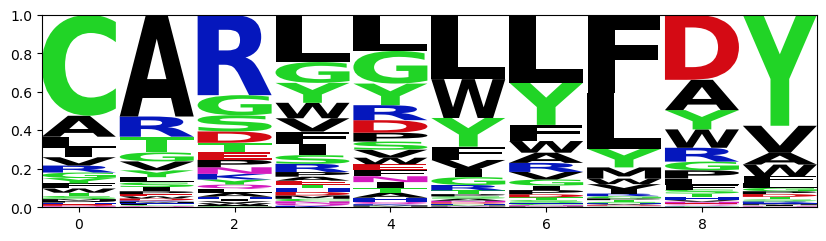

In [ ]:
#default dict with 0nvalues, outer key is numers from 0 to 9 and inner key are frommconfig.AMINOACID_ALPHABET
attr_dict = {key: {key: 0 for key in config.AMINOACID_ALPHABET} for key in range(10)}
    atr_for_pos = attr_df['DeepLIFT_GLOBAL_R10_v2.0-2'].apply(lambda x: x[0][pos]).values

for pos in range(10):
    aa_in_position = attr_df.slide.apply(lambda x: x[pos]).values
    atr_for_pos = attr_df['DeepLIFT_GLOBAL_R10_v2.0-2'].apply(lambda x: x[0][pos]).values
    for aa, attr in zip(aa_in_position, atr_for_pos):
        attr_dict[pos][aa] += attr

attr_per_aa_df = pd.DataFrame(attr_dict)
normalized_attr_df = attr_per_aa_df.div(attr_per_aa_df.sum(axis=0), axis=1).T

Logo(normalized_attr_df)